### VCM Research

### Difference-in-Differences (Demand)


In [1]:
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas 

### Equation 1

In [8]:
file_path = 'C:\\Users\\grandonb\\Desktop\\VCM\\VCM_Demand.csv'

# open the file and store the data in a data frame
df = pd.read_csv(file_path, low_memory=False)

# melt years columns
columns_to_melt = [str(i) for i in range(2004, 2022)]

# Melt the selected columns, using the column names as the id_vars
df = pd.melt(df, id_vars=['Project ID', 'Registry', 'Voluntary_Status', 'Scope', 'Type', 'Country', 'Total_Credits'], 
             value_vars=columns_to_melt, var_name='years', value_name='demand').dropna()

# Convert years to numeric
df['years'] = pd.to_numeric(df['years'])

# Convert surplus to numeric
df['demand'] = pd.to_numeric(df['demand'])

df 

,Project ID,Registry,Voluntary_Status,Scope,Type,Country,Total_Credits,years,demand
0,ACR102,ACR,Completed,Chemical_Processes,Reduction,United States of America,17666,2004,0
1,ACR103,ACR,Completed,Agriculture,Reduction,United States of America,44202,2004,0
2,ACR106,ACR,Completed,Waste_Management,Reduction,United States of America,109452,2004,0
3,ACR107,ACR,Completed,Industrial_Commercial,Reduction,Bolivia,1138,2004,0
4,ACR109,ACR,Completed,Industrial_Commercial,Reduction,United States of America,200000,2004,0
...,...,...,...,...,...,...,...,...,...
53977,VCS995,VCS,Registered,Forestry_Land_Use,Impermanent Removal,Uganda,144643,2021,23605
53978,VCS996,VCS,Registered,Forestry_Land_Use,Impermanent Removal,Kenya,257623,2021,5462
53979,VCS998,VCS,Registered,Household_Community,Reduction,Vietnam,29018,2021,0
53980,VCSOPR10,VCS,Transfer to another GHG program,Forestry_Land_Use,Mixed,United States of America,78497,2021,0


In [9]:
grouped = df.groupby('Country')
summary = grouped['Project ID'].nunique().reset_index(name='N')
summary = pd.merge(summary, grouped['demand'].describe()[['mean', 'std', 'min', 'max']].round(), on='Country')

df_summary = pd.DataFrame(summary)

df_summary

,Country,N,mean,std,min,max
0,Argentina,7,3206.0,12369.0,0.0,86986.0
1,Aruba,1,42736.0,74740.0,0.0,229077.0
2,Australia,5,9660.0,18585.0,0.0,85504.0
3,Bangladesh,40,2003.0,44738.0,0.0,1200000.0
4,Belize,3,20662.0,55283.0,0.0,235632.0
...,...,...,...,...,...,...
94,United States of America,693,12664.0,104417.0,0.0,6390607.0
95,Uruguay,9,30499.0,152519.0,0.0,1310380.0
96,Vietnam,24,8136.0,51129.0,0.0,736775.0
97,Zambia,12,25574.0,194299.0,0.0,2261722.0


In [10]:
# Specify the treatment group

treatment_group = ['Switzerland', 'Belize', 'Spain', 'Costa Rica', 'Paraguay', 
                   'New Zealand', 'Germany', 'United Kingdom', 'Colombia', 'Fiji']

# Create treatment and post_treatment columns
df['treatment'] = df['Country'].isin(treatment_group).astype(int)
df['post_treatment'] = (df['years'] >= 2018).astype(int)

# Fit the model using the ols function
model = smf.ols(formula = 'demand ~ treatment + post_treatment + treatment*post_treatment', data = df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     197.7
Date:                Mon, 13 Feb 2023   Prob (F-statistic):          1.52e-127
Time:                        21:59:30   Log-Likelihood:            -7.0598e+05
No. Observations:               53982   AIC:                         1.412e+06
Df Residuals:                   53978   BIC:                         1.412e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

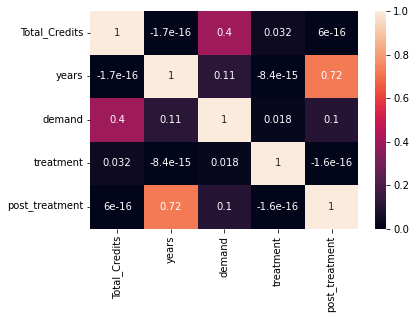

In [11]:
#print corr_matrix
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

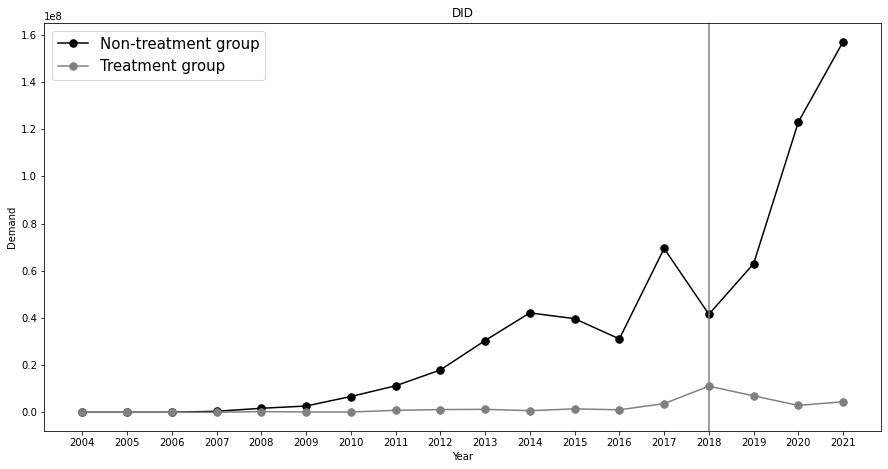

In [12]:
# Create a pivot table to summarize the surplus by year and treatment
ax = df.pivot_table(values='demand', index='years', columns='treatment', aggfunc='sum').plot(
    figsize=(15, 7.5),
    marker='.', 
    markersize=15, 
    title='DID',
    xlabel='Year',
    ylabel='Demand',
    # Set the x-axis ticks to match the years in the dataframe
    xticks=df['years'].drop_duplicates().sort_values().astype('int'),
    color=['black', 'gray']
)

# Add a vertical line to show the year of the policy change
ax.axvline(x=2018, color='gray', linestyle='-')
ax.legend(['Non-treatment group', 'Treatment group'], fontsize=15)

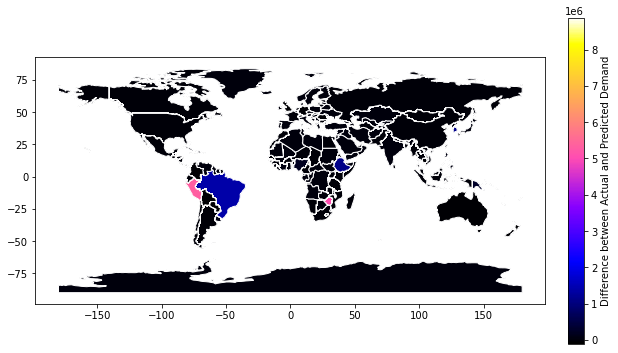

In [55]:
# Predict the surplus using the model
df['predicted_demand'] = model.predict()

# Calculate the difference between actual and predicted demand
df['difference'] = df['demand'] - df['predicted_demand']

# Load the GeoDataFrame with country borders
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Merge the GeoDataFrame with the results of the model
result = world.merge(df, left_on='name', right_on='Country', how='outer')
result['difference'] = result['difference'].fillna(0)

# Plot the choropleth map
ax = result.plot(column='difference', cmap='gnuplot2', figsize=(10, 6), edgecolor='white', missing_kwds={'color': 'lightgray'})

# Add a color bar
cbar = plt.colorbar(ax.collections[0], ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Difference between Actual and Predicted Demand')

# Show the plot
plt.show()

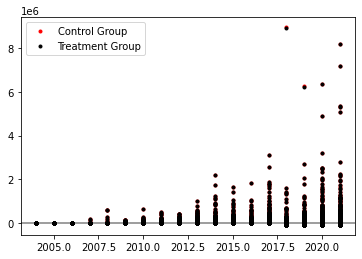

In [23]:
import statsmodels.formula.api as smf

# Fit a model without the treatment effect
control_model = smf.ols(formula = 'demand ~ post_treatment', data = df).fit()

# Fit the full model including the treatment effect
treatment_model = smf.ols(formula = 'demand ~ treatment + post_treatment + treatment*post_treatment', data = df).fit()

# Calculate the residuals for both models
df['residual_control'] = control_model.resid
df['residual_treatment'] = treatment_model.resid

# Plot the residuals against the time variable to visualize the parallel trend assumption
import matplotlib.pyplot as plt

plt.plot(round(df['years'],0), df['residual_control'], '.', label='Control Group', color = 'red')
plt.plot(round(df['years'],0), df['residual_treatment'], '.', label='Treatment Group', color = 'black')

plt.axhline(y=0, linestyle='-', color='black', alpha=0.5)
plt.legend()
plt.show()


### Placebo test 

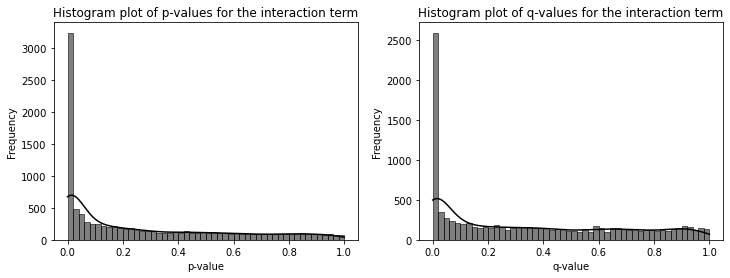

In [52]:
p_values = []

for i in range(10000):
    # set the seed for the random process
    random.seed(i)
    
    # create a list of countries that are not in the treatment group
    countries = list(set(countries for countries in df["Country"] if countries not in treatment_group))

    # select a random sample of countries from the list of non-treatment countries 
    # that has the same number of elements as the treatment group
    placebo_group = random.sample(countries, len(treatment_group))

    # create a new column in the dataframe indicating whether each country is in the placebo group
    df['placebo_treatment'] = df['Country'].isin(placebo_group).astype(int)

    # create a new column indicating whether the observation is post-treatment
    df['post_placebo_treatment'] = (df['years'] >= 2018).astype(int)

    model = smf.ols(formula = 'surplus ~ placebo_treatment + post_placebo_treatment + placebo_treatment*post_placebo_treatment', data = df).fit()

    p_values.append(model.pvalues[3])


rejected, q_values, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
   
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(p_values, bins = 50, kde = True, color = 'black', ax=ax[0])
ax[0].set_ylabel("Frequency")
ax[0].set_xlabel("p-value")
ax[0].set_title("Histogram plot of p-values for the interaction term")

sns.histplot(q_values, bins = 50, kde = True, color = 'black', ax=ax[1])
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("q-value")
ax[1].set_title("Histogram plot of q-values for the interaction term")

plt.show()

### Equation 2

In [31]:
file_path = 'C:\\Users\\grandonb\\Desktop\\VCM\\VCM_Demand.csv'

# open the file and store the data in a data frame
df = pd.read_csv(file_path, low_memory=False)

# melt years columns
columns_to_melt = [str(i) for i in range(2004, 2022)]

# Melt the selected columns, using the column names as the id_vars
df = pd.melt(df, id_vars=['Project ID', 'Registry', 'Voluntary_Status', 'Scope', 'Type', 'Country', 'Total_Credits'], 
             value_vars=columns_to_melt, var_name='years', value_name='demand').dropna()

# Convert years to numeric
df['years'] = pd.to_numeric(df['years'])

# Convert surplus to numeric
df['demand'] = pd.to_numeric(df['demand'])

# Specify the treatment group
treatment_group = ['Switzerland', 'Belize', 'Spain', 'Costa Rica', 'Paraguay','New Zealand', 'Germany', 'United Kingdom', 'Colombia', 'Fiji']

# Create treatment and post_treatment columns
df['treatment'] = df['Country'].isin(treatment_group).astype(int)
df['post_treatment'] = (df['years'] >= 2018).astype(int)

df = pd.get_dummies(df, columns=['Type'], prefix='Type')

project_types = ['Agriculture', 'Carbon_Capture_Storage', 'Chemical_Processes', 'Forestry_Land_Use','Household_Community', 'Industrial_Commercial', 'Renewable_Energy', 'Transportation','Waste_Management']

df_dummies = pd.get_dummies(df['Scope'], columns=project_types)

df = pd.concat([df, df_dummies], axis=1)

project_types = ['Type_Reduction', 'Type_Removal', 'Type_Mixed']
dummy_cols = ['Agriculture', 'Carbon_Capture_Storage', 'Chemical_Processes', 'Forestry_Land_Use','Household_Community', 'Industrial_Commercial', 'Renewable_Energy', 'Transportation', 'Waste_Management']

# Divide Total_Credits into categories
df['credit_size'] = pd.cut(df['Total_Credits'], 
                           bins=[0, 10000, 100000, 10000000, np.inf], 
                           labels=['less_than_10000', '10000_to_100000', '1000000_to_10000000', 'exceeding_10000000'])


df = pd.get_dummies(df, columns=['credit_size'], prefix='credit_size')

df = pd.get_dummies(df, columns=['Registry'], prefix='Registry')

# Get the names of the new dummy columns created
credit_size_dummies = [col for col in df.columns if 'credit_size' in col]

results = []

for project_type in project_types:
    for dummy_col in dummy_cols:
        for credit_size in credit_size_dummies:
            for registry in ['Registry_ACR', 'Registry_CAR', 'Registry_GOLD', 'Registry_VCS']:
                formula = f'demand ~ treatment + post_treatment + treatment*post_treatment + {project_type} + {dummy_col} + {credit_size} + {registry}'
                model = smf.ols(formula=formula, data=df).fit()
                results.append(model)


### Results

In [11]:
results = []
columns = ['Project Type', 'Scope', 'Credit Size', 'Registry', 'Standard Error', 'P-Value']
results_df = pd.DataFrame(columns=columns)

for project_type in project_types:
    for dummy_col in dummy_cols:
        for credit_size in credit_size_dummies:
            for registry in ['Registry_ACR', 'Registry_CAR', 'Registry_GOLD', 'Registry_VCS']:
                formula = f'surplus ~ treatment + post_treatment + treatment*post_treatment + {project_type} + {dummy_col} + {credit_size} + {registry}'
                model = smf.ols(formula=formula, data=df).fit()
                results.append({'Project Type': project_type, 'Scope': dummy_col, 'Credit Size': credit_size, 'Registry': registry, 
                                'Standard Error': round(model.bse[-1], 2), 'P-Value': round(model.pvalues[-1], 2)})

results_df = results_df.append(results, ignore_index=True)

results_df

/var/folders/3f/1rvnnl6n78163t47_hmr870h0000gn/T/ipykernel_89545/330098440.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(results, ignore_index=True)


,Project Type,Scope,Credit Size,Registry,Standard Error,P-Value
0,Type_Reduction,Agriculture,credit_size_less_than_10000,Registry_ACR,3750.74,0.99
1,Type_Reduction,Agriculture,credit_size_less_than_10000,Registry_CAR,2565.65,0.0
2,Type_Reduction,Agriculture,credit_size_less_than_10000,Registry_GOLD,1896.1,0.03
3,Type_Reduction,Agriculture,credit_size_less_than_10000,Registry_VCS,1761.52,0.0
4,Type_Reduction,Agriculture,credit_size_10000_to_100000,Registry_ACR,3745.4,0.63
...,...,...,...,...,...,...
427,Type_Mixed,Waste_Management,credit_size_1000000_to_10000000,Registry_VCS,1767.8,0.0
428,Type_Mixed,Waste_Management,credit_size_exceeding_10000000,Registry_ACR,3691.29,0.46
429,Type_Mixed,Waste_Management,credit_size_exceeding_10000000,Registry_CAR,2445.52,0.0
430,Type_Mixed,Waste_Management,credit_size_exceeding_10000000,Registry_GOLD,1846.94,0.14


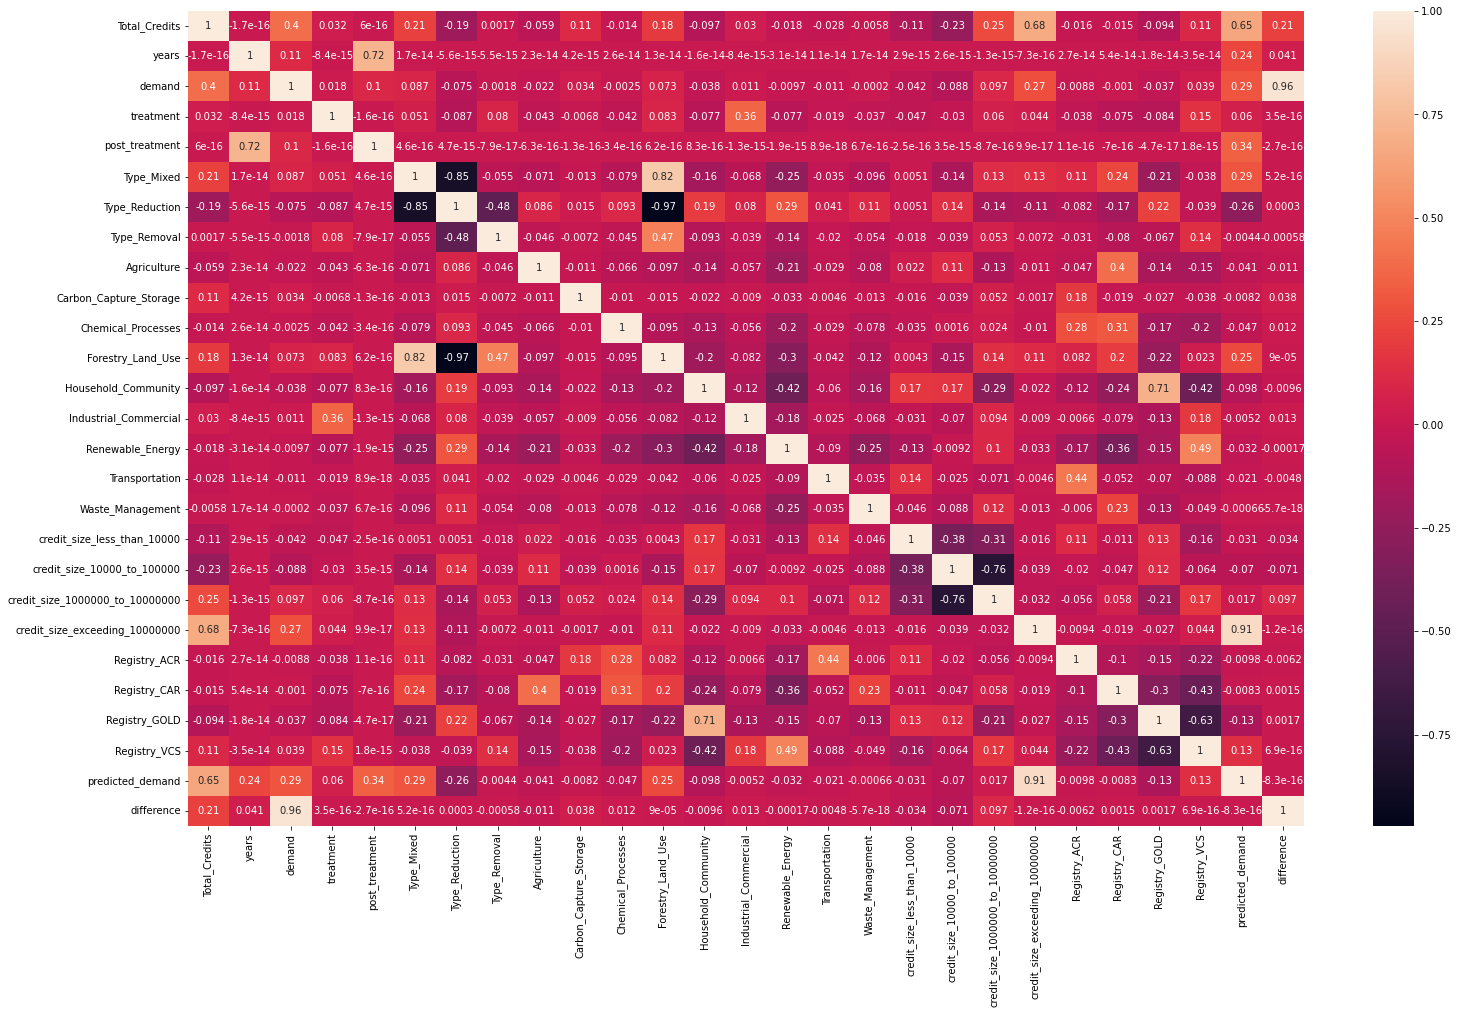

In [38]:
#print corr_matrix for all variables in equation 2
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(corr_matrix, annot=True, ax=ax)

plt.show()

### Alternative Approach

In [51]:
file_path = 'C:\\Users\\grandonb\\Desktop\\VCM\\VCM_Demand.csv'

# open the file and store the data in a data frame
df = pd.read_csv(file_path, low_memory=False)

# melt years columns
columns_to_melt = [str(i) for i in range(2004, 2022)]

# Melt the selected columns, using the column names as the id_vars
df = pd.melt(df, id_vars=['Project ID', 'Registry', 'Voluntary_Status', 'Scope', 'Type', 'Country', 'Total_Credits'], 
             value_vars=columns_to_melt, var_name='years', value_name='demand').dropna()

# Convert years to numeric
df['years'] = pd.to_numeric(df['years'])

# Convert surplus to numeric
df['demand'] = pd.to_numeric(df['demand'])

# Specify the treatment group
treatment_group = ['Switzerland', 'Belize', 'Spain', 'Costa Rica', 'Paraguay', 
                   'New Zealand', 'Germany', 'United Kingdom', 'Colombia', 'Fiji']

# Create treatment and post_treatment columns
df['treatment'] = df['Country'].isin(treatment_group).astype(int)
df['post_treatment'] = (df['years'] >= 2018).astype(int)

# Divide Total_Credits into categories
df['credit_size'] = pd.cut(df['Total_Credits'], 
                           bins=[0, 10000, 100000, 10000000, np.inf], 
                           labels=['less than 10,000', '10,000 to 100,000', '1,000,000 to 10,000,000', 'exceeding 10,000,000'])

# Fit separate regression models for each category of Total_Credits
for size in df['credit_size'].unique():
    credit_size_df = df[df['credit_size'] == size]
    model = smf.ols(formula = 'demand ~ treatment + post_treatment + treatment*post_treatment', data = credit_size_df).fit()
    print(f"Model for credit size: {size}")
    print(model.summary())

Model for credit size: 10,000 to 100,000
                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     184.5
Date:                Mon, 13 Feb 2023   Prob (F-statistic):          2.26e-118
Time:                        22:37:17   Log-Likelihood:            -2.6597e+05
No. Observations:               25776   AIC:                         5.319e+05
Df Residuals:                   25772   BIC:                         5.320e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [53]:
df = pd.get_dummies(df, columns=['Type'], prefix='Type')

project_types = ['Agriculture', 'Carbon_Capture_Storage', 'Chemical_Processes', 'Forestry_Land_Use',
                 'Household_Community', 'Industrial_Commercial', 'Renewable_Energy', 'Transportation',
                 'Waste_Management']

df_dummies = pd.get_dummies(df['Scope'], columns=project_types)

df = pd.concat([df, df_dummies], axis=1)

project_types = ['Type_Reduction', 'Type_Removal', 'Type_Mixed']
dummy_cols = ['Agriculture', 'Carbon_Capture_Storage', 'Chemical_Processes', 'Forestry_Land_Use','Household_Community', 'Industrial_Commercial', 'Renewable_Energy', 'Transportation', 'Waste_Management']

results = []

for project_type in project_types:
    for dummy_col in dummy_cols:
        formula = f'demand ~ treatment + post_treatment + treatment*post_treatment + {project_type} + {dummy_col}'
        model = smf.ols(formula=formula, data=df).fit()
        results.append(model)

# You can access the summary of each regression by using:
for result in results:
    print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     182.0
Date:                Mon, 13 Feb 2023   Prob (F-statistic):          8.83e-193
Time:                        22:37:42   Log-Likelihood:            -7.0582e+05
No. Observations:               53982   AIC:                         1.412e+06
Df Residuals:                   53976   BIC:                         1.412e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     202.7
Date:                Mon, 13 Feb 2023   Prob (F-statistic):          6.92e-215
Time:                        22:37:42   Log-Likelihood:            -7.0577e+05
No. Observations:               53982   AIC:                         1.412e+06
Df Residuals:                   53976   BIC:                         1.412e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               